# Analysis of clonesig power to distinguish close clones better by leveraging signatures
The objective of this notebook is to illustrate a proof of concept case of Clonesig. Indeed, by leveraging two types of information for each mutation, the VAF and the mutation type (in association with mutational signatures), Clonesig should have increased power to distinguish clones close in CCF if they have distinct mutational patterns. To illustrate that, we have simulated tumor samples with 2 clones, with 10 distinct CCF distance (between $0.03$ and $0.9$), 30 distinct mutational signatures mixtures, with cosine distance between the two profiles linearly spaced between $0$ and $0.8$. For each case, the number of mutations varies among $\{30, 100, 300, 1000\}$, the diploid proportion of the genome $\{0.1, 0.5, 0.9\}$, and the sequencing depth $\{100, 500\}$. We observe then in which cases Clonesig is able to detect 2 clones. We compare this distinguishing power to the other methods that account for both mutation frequencies and signatures: Palimpsest, TrackSig and TrackSigFreq.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Patch
import seaborn as sns
import numpy as np
import pandas as pd
import os
from statsmodels.stats.multitest import multipletests
from pathlib import Path

pd.options.display.max_columns = 200

method_color_dict = {'ccube': '#548ebb', 'clonesig': '#fc9d53',
                     'deconstructsigs':'#793d66', 'palimpsest':'#e45683',
                     'pyclone': '#87d0bd', 'sciclone': '#e1f5aa',
                     'tracksig': '#c4c3f9', 'tracksigfreq': '#8942fc'}
hatch_dict = {'prefit': '/', 'cancertype': '.', 'cancer_type': '.',
             'all': '', 'all_nuclonal': '+'}
sns.set_context("poster", font_scale=2)
mpl.rcParams['hatch.linewidth'] = 3
pd.options.display.max_columns = 200
os.chdir('..')
output_path = '20200515_paper_figures/power_eval'
Path(output_path).mkdir(parents=True, exist_ok=True)
import warnings
warnings.filterwarnings("ignore")

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [3]:
clonesig_res = pd.read_csv('20200513_eval_clonesig_power_2clones.csv', sep='\t')

In [4]:
clonesig_res = clonesig_res.assign(phi_dist=np.round(clonesig_res.phi_dist, 2))
clonesig_res = clonesig_res.assign(min_dist=np.round(clonesig_res.min_dist, 2))


In [5]:
clonesig_res.head()

,nb_pi,nb_phi,depth,perc_diploid,nb_clones,nb_mut,nb_sig,nb_sig_fit,min_dist,max_dist,avg_dist,avg_major_cn,actual_perc_diploid,avg_tot_cn,method,setting,dof,phi_dist,fitted_nb_clones,ll_ratio,pval,score2C_auc,score2C_accuracy,score2C_sensitivity,score2C_specificity,score2C_precision,timestamp
0,0,0,100,0.1,2,30,47,10.0,0.21,0.213397,0.213397,2.033333,0.066667,3.133333,clonesig,prefit,8,0.03,2.0,8.091268,0.210001,0.488688,0.533333,0.153846,0.823529,0.153846,1.589399e+09
1,0,0,100,0.1,2,30,47,47.0,0.21,0.213397,0.213397,2.033333,0.066667,3.133333,clonesig,all,21,0.03,1.0,0.002378,0.999989,0.500000,0.566667,0.000000,1.000000,0.000000,1.589399e+09
2,0,0,100,0.1,2,30,47,NaN,0.21,0.213397,0.213397,2.033333,0.066667,3.133333,tracksig,all,21,0.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.589399e+09
3,0,0,100,0.1,2,30,47,NaN,0.21,0.213397,0.213397,2.033333,0.066667,3.133333,tracksig,prefit,21,0.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.589399e+09
4,0,0,100,0.1,2,30,47,NaN,0.21,0.213397,0.213397,2.033333,0.066667,3.133333,tracksigfreq,all,21,0.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.589399e+09


In [6]:
clonesig_res = clonesig_res.assign(qmin_dist=pd.qcut(clonesig_res.min_dist, 10, labels=False))
clonesig_res_ = pd.merge(clonesig_res, clonesig_res.groupby('qmin_dist').min_dist.mean().round(2), left_on='qmin_dist', right_index=True)
#clonesig_res_.head()
uu=pd.pivot_table(index='phi_dist', columns='min_dist_y', values='score2C_auc', aggfunc='mean', data=clonesig_res_[clonesig_res_.method=="clonesig"]).sort_index(ascending=False)
uu

min_dist_y,0.04,0.1,0.15,0.21,0.3,0.4,0.5,0.56,0.65,0.79
phi_dist,,,,,,,,,,
0.89,0.981632,0.988165,0.989714,0.987569,0.992608,0.991399,0.988849,0.991363,0.990483,0.994925
0.62,0.912258,0.911879,0.920828,0.921645,0.928388,0.934016,0.935285,0.932749,0.933253,0.951650
0.42,0.832072,0.835485,0.841892,0.850756,0.851558,0.872257,0.866265,0.880247,0.890990,0.923147
0.29,0.750459,0.770240,0.781756,0.794150,0.789068,0.806164,0.807253,0.829068,0.838017,0.865676
0.20,0.652434,0.687817,0.688703,0.694127,0.699683,0.735419,0.740023,0.748158,0.763332,0.814180
0.14,0.585535,0.607835,0.603868,0.606544,0.619325,0.649390,0.664672,0.677926,0.679164,0.751749
0.10,0.528267,0.541478,0.553492,0.549865,0.565693,0.585119,0.596279,0.611322,0.614030,0.670682
0.07,0.510141,0.518670,0.515237,0.521188,0.531835,0.535654,0.546069,0.558096,0.564806,0.608818
0.05,0.503240,0.506297,0.508402,0.511200,0.514005,0.512019,0.522357,0.523392,0.524283,0.554041


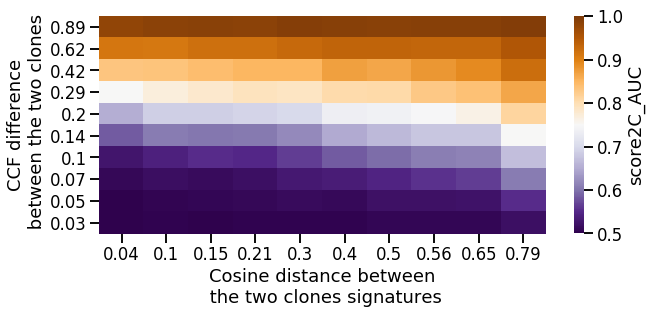

In [7]:
#uu=pd.pivot_table(index='phi_dist', columns='min_dist', values='accuracy', aggfunc='mean', data=clonesig_res)
sns.set_context('talk')
plt.figure(figsize=(10, 4))
ax=sns.heatmap(uu, cmap='PuOr_r', vmin=0.5, vmax=1, cbar_kws={'label': 'score2C_AUC'})
ax.set_xlabel("Cosine distance between\n the two clones signatures")
ax.set_ylabel("CCF difference\n between the two clones")
plt.savefig('{}/clonesig_separation_power.pdf'.format(output_path), bbox_inches='tight')


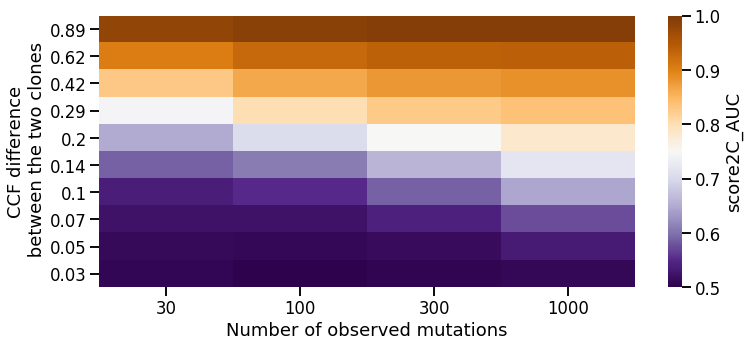

In [8]:
uu=pd.pivot_table(index='phi_dist', columns='nb_mut', values='score2C_auc', aggfunc='mean', data=clonesig_res_[clonesig_res_.method=="clonesig"]).sort_index(ascending=False)
sns.set_context('talk')
plt.figure(figsize=(12, 5))
ax=sns.heatmap(uu, cmap='PuOr_r', vmin=0.5, vmax=1, cbar_kws={'label': 'score2C_AUC'})
ax.set_xlabel("Number of observed mutations")
ax.set_ylabel("CCF difference\n between the two clones")
plt.savefig('{}/clonesig_separation_power_nbmut.pdf'.format(output_path), bbox_inches='tight')


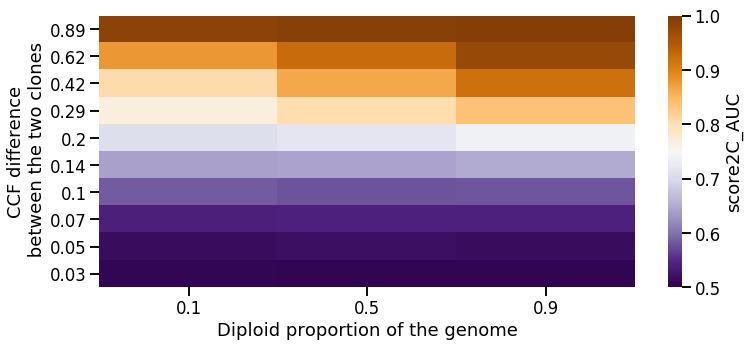

In [9]:
uu=pd.pivot_table(index='phi_dist', columns='perc_diploid', values='score2C_auc', aggfunc='mean', data=clonesig_res_[clonesig_res_.method=="clonesig"]).sort_index(ascending=False)
sns.set_context('talk')
plt.figure(figsize=(12, 5))
ax=sns.heatmap(uu, cmap='PuOr_r', vmin=0.5, vmax=1, cbar_kws={'label': 'score2C_AUC'})

ax.set_xlabel("Diploid proportion of the genome")
ax.set_ylabel("CCF difference\n between the two clones")
plt.savefig('{}/separation_power_perc_dip.pdf'.format(output_path), bbox_inches='tight')


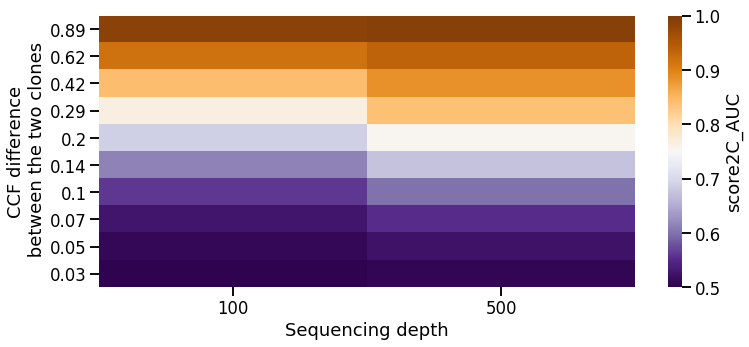

In [10]:
uu=pd.pivot_table(index='phi_dist', columns='depth', values='score2C_auc', aggfunc='mean', data=clonesig_res_[clonesig_res_.method=="clonesig"]).sort_index(ascending=False)
sns.set_context('talk')
plt.figure(figsize=(12, 5))
ax=sns.heatmap(uu, cmap='PuOr_r', vmin=0.5, vmax=1, cbar_kws={'label': 'score2C_AUC'})

ax.set_xlabel("Sequencing depth")
ax.set_ylabel("CCF difference\n between the two clones")
plt.savefig('{}/clonesig_separation_power_depth.pdf'.format(output_path), bbox_inches='tight')


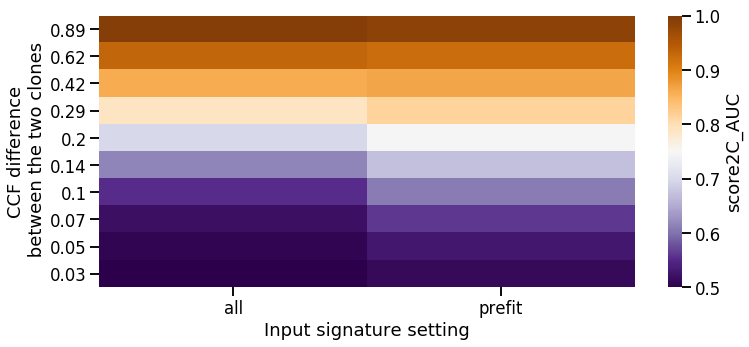

In [11]:
uu=pd.pivot_table(index='phi_dist', columns='setting', values='score2C_auc', aggfunc='mean', data=clonesig_res_[clonesig_res_.method=="clonesig"]).sort_index(ascending=False)
sns.set_context('talk')
plt.figure(figsize=(12, 5))
ax=sns.heatmap(uu, cmap='PuOr_r', vmin=0.5, vmax=1, cbar_kws={'label': 'score2C_AUC'})

ax.set_xlabel("Input signature setting")
ax.set_ylabel("CCF difference\n between the two clones")
plt.savefig('{}/clonesig_separation_power_setting.pdf'.format(output_path), bbox_inches='tight')


In [12]:
clonesig_res = clonesig_res.assign(qmin_dist=pd.qcut(clonesig_res.min_dist, 10, labels=False))
clonesig_res_ = pd.merge(clonesig_res, clonesig_res.groupby('qmin_dist').min_dist.mean().round(2), left_on='qmin_dist', right_index=True)
aa=clonesig_res_.dropna(subset=['score2C_auc']).groupby(['nb_pi', 'nb_phi', 'depth', 'perc_diploid', 'nb_clones', 'nb_mut']).method.nunique().to_frame().reset_index()
aa = aa.assign(nb_method=aa.method).drop(columns=['method'])
clonesig_res_complete = pd.merge(clonesig_res_, aa, on=['nb_pi', 'nb_phi', 'depth', 'perc_diploid', 'nb_clones', 'nb_mut'])
clonesig_res_filter = clonesig_res_complete[clonesig_res_complete.nb_method==4]


method_name_dict = {'clonesig': 'CloneSig', 'tracksig': 'TrackSig',
                    'tracksigfreq': 'TrackSigFreq',
                    'palimpsest': 'Palimpsest'}




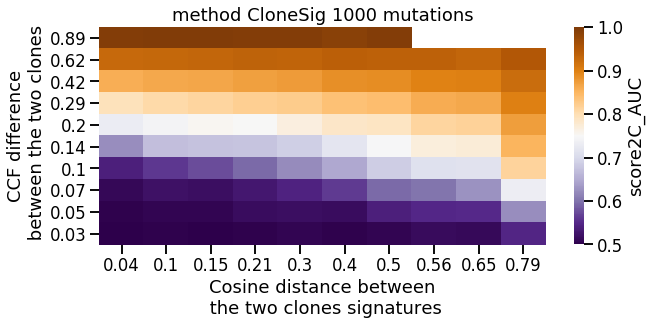

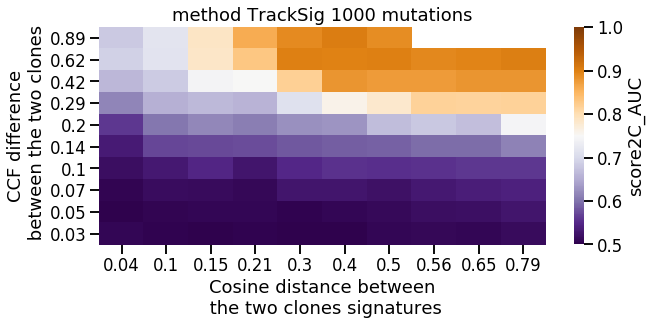

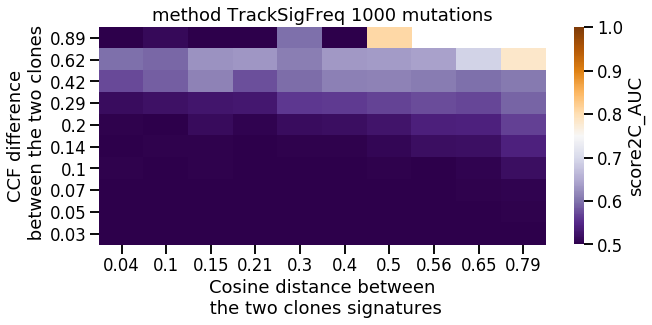

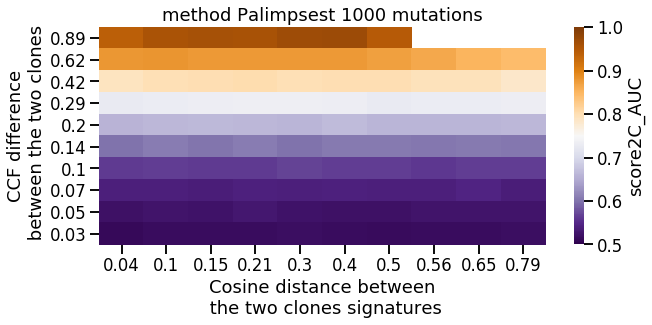

In [13]:
for method in ('clonesig', 'tracksig', 'tracksigfreq', 'palimpsest'):
    uu_1000=pd.pivot_table(index='phi_dist', columns='min_dist_y', values='score2C_auc', aggfunc='mean', data=clonesig_res_filter[(clonesig_res_filter.method==method)&(clonesig_res_filter.nb_mut==1000)]).sort_index(ascending=False)
    sns.set_context('talk')
    plt.figure(figsize=(10, 4))
    ax=sns.heatmap(uu_1000, cmap='PuOr_r', vmin=0.5, vmax=1, cbar_kws={'label': 'score2C_AUC'})
    ax.set_xlabel("Cosine distance between\n the two clones signatures")
    ax.set_ylabel("CCF difference\n between the two clones")
    ax.set_title('method {} 1000 mutations'.format(method_name_dict[method]))
    plt.savefig('{}/{}_separation_power_1000.pdf'.format(output_path, method),
                bbox_inches='tight')


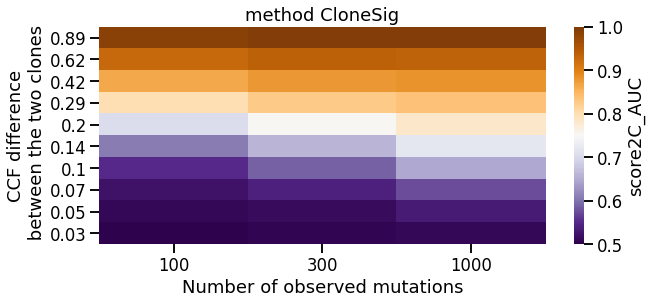

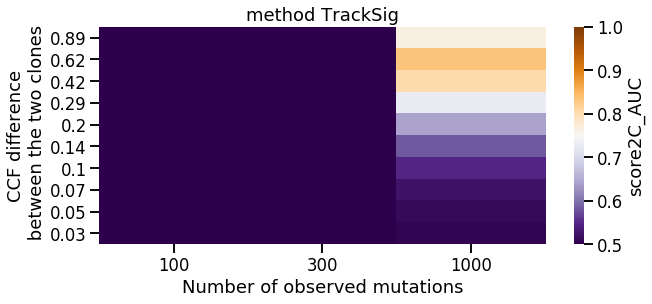

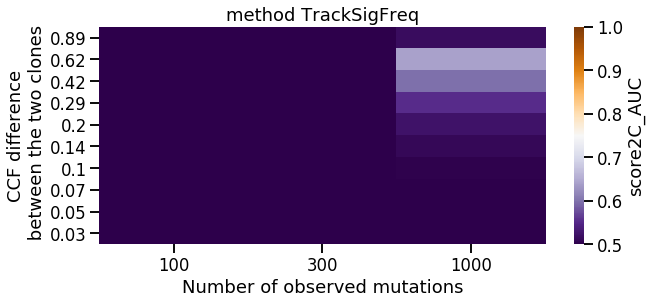

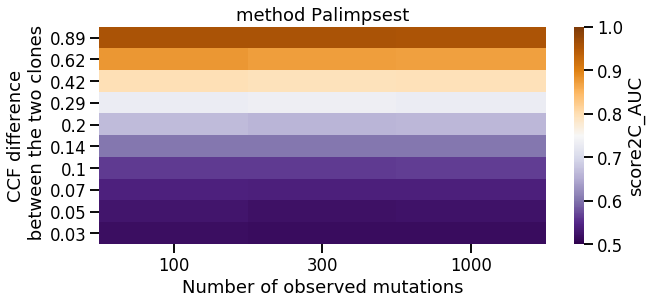

In [14]:
for method in ('clonesig', 'tracksig', 'tracksigfreq', 'palimpsest'):
    uu_mut=pd.pivot_table(index='phi_dist', columns='nb_mut', values='score2C_auc', aggfunc='mean', data=clonesig_res_filter[(clonesig_res_filter.method==method)]).sort_index(ascending=False)
    sns.set_context('talk')
    plt.figure(figsize=(10, 4))
    ax=sns.heatmap(uu_mut, cmap='PuOr_r', vmin=0.5, vmax=1, cbar_kws={'label': 'score2C_AUC'})
    ax.set_xlabel("Number of observed mutations")
    ax.set_ylabel("CCF difference\n between the two clones")
    ax.set_title('method {}'.format(method_name_dict[method]))
    plt.savefig('{}/{}_separation_power_nb_mut_comp.pdf'.format(output_path, method),
                bbox_inches='tight')
